# 小组成员
 1. 信息2301, 2310650118, 洪菁曼 （组长）
 2. 信息2302, 2310650219, 安雨琪

# 工作日志
## 问题一（安雨琪）
1. 2026-01-03 数据预处理 主要是将附件2各行重命名转换日期，附件一附件二通过单品编码的主键合并数据（数据库）
     * 预处理时发现反复运行合并数据会报错，删除已有重复列解决这个问题
2. 2026-01-03 基础分析 （1）将单品销售量前十列出 （2）6个品类年度分析、季度分析 （3）周末对比平常
     * 基础分析的一些方法不确定要不要做两个人讨论了一下决定从年、季度、周末入手
3. 2026-01-03 聚类分析 进行品类的聚类分组：分了三个类 、随机森林（回归分析）来说明各品类之间的相关关系；用spearman来进行销量和价格的相关性分析
     * 相关分析，一开始只采用了聚类分析和随机森林，发现描述的不够准确不太适合这类问题，进而选择用spearman和person。因为规律大概率不是线性的 所以用的spearman。spearman中一开始写的冗余代码太多一直在重复。后改进了写法，用封装的函数来优化代码

 智能商务数据分析实践  课程考核题目及要求

任务要求：
选题二选一完成，分组2~3人一组。
独立实践报告采用Jupyter写，最后在线提交notebook原文件以及其导出的PDF文件，无需包含原始数据，打包成ZIP包。
Jupyter笔记的的第一个Markdown单元格内必须写成员的班级、学号、姓名

报告的第二个Markdown单元格，写工作日志，至少4条以上，内容写标志性、自己做过努力的、跳过的坑。

1. 202x-xx-xx 对数据进行了...统计分析
1. 202x-xx-xx 补充了...分析
1. 202x-xx-xx 采用...交叉验证对选择模型..
1. ...
报告必须有相应的分析或说明文字，需要必要的完整中间过程（程序和输出结果）
报告最多分两级标题（章和节）
成员多于1人的小组，在报告每个第二级（节）的末尾以陈述方式说明成员的工作。

> 张三承担...完成...


选题2：蔬菜类商品的自动定价与补货决策问题

问题：
在生鲜商超中，一般蔬菜类商品的保鲜期都比较短，且品相随销售时间的增加而变差，大部分品种如当日未售出，隔日就无法再售。因此，商超通常会根据各商品的历史销售和需求情况每天进行补货。

由于商超销售的蔬菜品种众多、产地不尽相同，而蔬菜的进货交易时间通常在凌晨 3:00-4:00，为此商家须在不确切知道具体单品和进货价格的情况下，做出当日各蔬菜品类的补货决策。蔬菜的定价一般采用“成本加成定价”方法，商超对运损和品相变差的商品通常进行打折销售。可靠的市场需求分析，对补货决策和定价决策尤为重要。从需求侧来看，蔬菜类商品的销售量与时间往往存在一定的关联关系；从供给侧来看，蔬菜的供应品种在4月至10月较为丰富，商超销售空间的限制使得合理的销售组合变得极为重要。

附件1给出了某商超经销的6个蔬菜品类的商品信息；附件2和附件3分别给出了该商超2020年7月1日至2023年6月30日各商品的销售流水明细与批发价格的相关数据；附件4给出了各商品近期的损耗率数据。

请根据附件和实际情况建立数学模型解决以下问题：
问题1 蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。
问题2 考虑商超以品类为单位做补货计划，请分析各蔬菜品类的销售总量与成本加成定价的关系，并给出各蔬菜品类未来一周(2023 年 7 月 1-7 日)的日补货总量和定价策略，使得商超收益最大。
问题3 因蔬菜类商品的销售空间有限，商超希望进一步制定单品的补货计划，要求可售单品总数控制在 27-33 个，且各单品订购量满足最小陈列量 2.5 千克的要求。根据 2023 年 6 月 24-30 日的可售品种，给出 7 月 1 日的单品补货量和定价策略，在尽量满足市场对各品类蔬菜商品需求的前提助，请给出你们的意见和理由。

数据文件：
附件1 数据文件是6个蔬菜品类的商品信息
附件2 销售流水明细数据
附件3 蔬菜类商品的批发价格
附件4 蔬菜类商品的近期损耗率
附件说明：
附件1中部分单品名称包含的数字编号表示不同的供应来源。
附件4中的损耗率反映了近期商品的损耗情况，通过近期盘点周期的数据计算得到。


# 数据预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import warnings
import os
import seaborn as sns
warnings.filterwarnings('ignore')

# 设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def smart_loader(file_path):
    """智能加载器：读取 Excel -> 优化数据类型 -> 保存 Parquet 缓存"""

    cache_file = os.path.splitext(file_path)[0] + '.parquet'
    
    # 1. 命中缓存：直接读取
    if os.path.exists(cache_file):
        print(f"读取缓存: {cache_file}")
        return pd.read_parquet(cache_file)
    
    # 2. 未命中缓存：读取原始文件
    print(f"读取原始文件: {file_path}")
    if file_path.endswith('.xlsx') or file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)

    # 字符串 -> 分类    
    for col in df.select_dtypes(include=['object']).columns:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df)
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    # 日期列转换
    if '销售日期' in df.columns:
        df['销售日期'] = pd.to_datetime(df['销售日期'])

    # 3. 保存为 Parquet
    df.to_parquet(cache_file, engine='pyarrow')
    print(f"已创建缓存文件: {cache_file}")
    
    return df

# 使用方式
# df = smart_loader('your_file.xlsx')

# 问题1
蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。

品类：分类名称

In [3]:
try:
    raw_sales = smart_loader('./选题2-蔬菜自动定价与补货决策/附件2.xlsx')
    raw_category = smart_loader('./选题2-蔬菜自动定价与补货决策/附件1.xlsx')
except Exception as e:
    print(f" 读取失败: {e}")
    exit()

读取缓存: ./选题2-蔬菜自动定价与补货决策/附件2.parquet
读取缓存: ./选题2-蔬菜自动定价与补货决策/附件1.parquet


In [4]:
def preprocess_for_q1(df_sales, df_category):
    df = df_sales.copy()
    # df_sales 列为: [销售日期, 扫码销售时间, 单品编码, 销量(千克), 销售单价(元/千克), 销售类型, 是否打折销售]
    df.columns = ['销售日期', '扫码时间', '单品编码', '销量', '单价', '销售类型', '是否打折']
    df = df[df['销售类型'] == '销售'] 
    
    # 保留df_sales中的所有行，并从category_info中添加匹配的'分类名称'和'单品名称'信息，存入df
    category_info = df_category[['单品编码', '分类名称', '单品名称']].drop_duplicates()
    df = pd.merge(df, category_info, on='单品编码', how='left')
    df['分类名称'] = df['分类名称'].astype(str).replace('nan', '未知品类')
    
    # 时间特征提取：Q1 需要周、月、季的分布规律
    df['日期'] = df['销售日期']
    df['年份'] = df['日期'].dt.year
    df['季度'] = df['日期'].dt.quarter
    df['月份'] = df['日期'].dt.month
    df['星期'] = df['日期'].dt.weekday # 0-6
    df['是否周末'] = df['星期'].isin([5, 6])
    
    # 6. 删除不必要的中间列
    df.drop(columns=['销售日期', '扫码时间', '销售类型'], inplace=True)
    
    print(f"Q1 数据准备完毕，形状: {df.shape}")
    return df

In [5]:
df_q1 = preprocess_for_q1(raw_sales, raw_category)
df_q1.info()

Q1 数据准备完毕，形状: (878042, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878042 entries, 0 to 878041
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   单品编码    878042 non-null  int64         
 1   销量      878042 non-null  float64       
 2   单价      878042 non-null  float64       
 3   是否打折    878042 non-null  category      
 4   分类名称    878042 non-null  object        
 5   单品名称    878042 non-null  object        
 6   日期      878042 non-null  datetime64[ns]
 7   年份      878042 non-null  int32         
 8   季度      878042 non-null  int32         
 9   月份      878042 non-null  int32         
 10  星期      878042 non-null  int32         
 11  是否周末    878042 non-null  bool          
dtypes: bool(1), category(1), datetime64[ns](1), float64(2), int32(4), int64(1), object(2)
memory usage: 55.3+ MB


In [6]:
def check_price_consistency(df):
    """
    检查每日各单品的单价是否一致
    输入: df (销售流水数据)
    """
    print("🔍 开始检查价格一致性...")
    
    # 1. 按 [日期, 单品编码] 分组，计算每天每个单品有多少个不同的价格
    # nunique() 方法返回唯一值的数量
    price_counts = df.groupby(['日期', '单品编码'])['单价'].nunique()
    
    # 2. 筛选出价格数量 > 1 的记录（即价格不一致的情况）
    inconsistent_records = price_counts[price_counts > 1]
    
    # 3. 统计结果
    total_combinations = len(price_counts)
    inconsistent_count = len(inconsistent_records)
    inconsistent_ratio = inconsistent_count / total_combinations * 100
    
    print(f"📊 检查结果:")
    print(f"   - 总共检查了 {total_combinations} 个 [日期-单品] 组合")
    print(f"   - 发现 {inconsistent_count} 个组合存在多重价格")
    print(f"   - 不一致比例: {inconsistent_ratio:.2f}%")
    
    if inconsistent_count > 0:
        print("\n👀 价格不一致示例 (前5个):")
        # 展示具体是哪些天、哪些商品价格不一样，以及价格范围
        for (date, sku), count in inconsistent_records.head(5).items():
            # 获取那一天的所有价格记录
            subset = df[(df['日期'] == date) & (df['单品编码'] == sku)]
            prices = subset['单价'].unique()
            print(f"   日期: {date.date()} | 单品: {sku} | 价格数量: {count} | 价格列表: {prices}")
            
            # 检查是否是因为“是否打折”字段导致的
            # 查看打折和不打折的平均价
            if '是否打折' in df.columns:
                 print(f"      -> 打折情况: {subset['是否打折'].unique()}")
        
    return inconsistent_records

# === 使用方法 ===
# 假设 df2 是你加载好的销售流水数据
inconsistent_df = check_price_consistency(df_q1)

🔍 开始检查价格一致性...
📊 检查结果:
   - 总共检查了 46595 个 [日期-单品] 组合
   - 发现 7076 个组合存在多重价格
   - 不一致比例: 15.19%

👀 价格不一致示例 (前5个):
   日期: 2020-07-01 | 单品: 102900005116530 | 价格数量: 2 | 价格列表: [18. 16.]
      -> 打折情况: ['否', '是']
Categories (2, object): ['否', '是']
   日期: 2020-07-01 | 单品: 102900005118831 | 价格数量: 2 | 价格列表: [6.9 6.4]
      -> 打折情况: ['否', '是']
Categories (2, object): ['否', '是']
   日期: 2020-07-01 | 单品: 102900005119975 | 价格数量: 2 | 价格列表: [6. 4.]
      -> 打折情况: ['否', '是']
Categories (2, object): ['否', '是']
   日期: 2020-07-02 | 单品: 102900005115779 | 价格数量: 2 | 价格列表: [8.  3.4]
      -> 打折情况: ['否', '是']
Categories (2, object): ['否', '是']
   日期: 2020-07-02 | 单品: 102900005115960 | 价格数量: 2 | 价格列表: [0.7 3.2]
      -> 打折情况: ['是', '否']
Categories (2, object): ['否', '是']


In [7]:
def generate_daily_data(df_flow):
    """
    将流水数据聚合为日级数据（包含加权价格计算）
    """
    print("📅 正在生成日级别数据...")
    
    # 1. 确保有销售额列
    if '销售额' not in df_flow.columns:
        df_flow['销售额'] = df_flow['销量'] * df_flow['单价']
    
    # ================= A. 单品粒度 (SKU Level) - 用于 Q3 =================
    # 按 [日期, 单品编码] 聚合
    # 注意：保留分类名称和单品名称以便后续使用
    df_daily_sku = df_flow.groupby(['日期', '单品编码', '分类名称', '单品名称']).agg({
        '销量': 'sum',
        '销售额': 'sum',
    }).reset_index()
    
    # 计算加权平均单价 (Weighted Average Price)
    df_daily_sku['加权单价'] = df_daily_sku['销售额'] / df_daily_sku['销量']
    
    # ================= B. 品类粒度 (Category Level) - 用于 Q1/Q2 =================
    # 按 [日期, 分类名称] 聚合
    df_daily_cat = df_flow.groupby(['日期', '分类名称']).agg({
        '销量': 'sum',
        '销售额': 'sum'
    }).reset_index()
    
    # 计算品类加权均价
    df_daily_cat['加权单价'] = df_daily_cat['销售额'] / df_daily_cat['销量']
    
    # 添加时间特征 (方便后续分析)
    for df in [df_daily_sku, df_daily_cat]:
        df['年份'] = df['日期'].dt.year
        df['月份'] = df['日期'].dt.month
        df['季度'] = df['日期'].dt.quarter
        df['星期'] = df['日期'].dt.weekday  # 0-6
        df['是否周末'] = df['星期'] >= 5

    print(f"✅ 生成完成:\n   - 单品日数据: {df_daily_sku.shape}\n   - 品类日数据: {df_daily_cat.shape}")
    return df_daily_sku, df_daily_cat

# === 使用示例 ===
# 假设 data_q1 是你清洗好的流水数据
df_sku_daily, df_cat_daily = generate_daily_data(df_q1)

# 打印看一眼单价的区别
print("\n数据示例 (单品日级):")
print(df_sku_daily[['日期', '单品名称', '销量', '加权单价']].head())

📅 正在生成日级别数据...
✅ 生成完成:
   - 单品日数据: (46595, 12)
   - 品类日数据: (6474, 10)

数据示例 (单品日级):
          日期  单品名称      销量  加权单价
0 2020-07-01    苋菜   6.841   6.0
1 2020-07-01  云南生菜  41.966   8.0
2 2020-07-01   竹叶菜  11.352   6.0
3 2020-07-01   小白菜   4.288  16.0
4 2020-07-01   上海青  11.476  10.0


## 基础分析

In [8]:
def analyze_distribution_patterns(data):
    # 1. 各品类每日销量的箱线图 (分析分布集中度和离群点)
    plt.figure(figsize=(12, 6))
    # 汇总为 [日期, 分类名称] 的总销量
    daily_cat_sales = data.groupby(['日期', '分类名称'])['销量'].sum().reset_index()
    
    sns.boxplot(x='分类名称', y='销量', data=daily_cat_sales)
    plt.title('各蔬菜品类每日销量分布箱线图')
    plt.ylabel('日销量 (千克)')
    plt.yscale('log') # 因为有些销量太大，用对数坐标看分布更清晰
    plt.show()
    
    # 2. 核心品类的月度趋势图 (分析季节性)
    # 按月汇总
    monthly_sales = data.groupby(['年份', '月份', '分类名称'])['销量'].sum().reset_index()
    monthly_sales['年月'] = pd.to_datetime(monthly_sales['年份'].astype(str) + '-' + monthly_sales['月份'].astype(str) + '-01')

    plt.figure(figsize=(14, 6)) 
    sns.lineplot(x='年月', y='销量', hue='分类名称', data=monthly_sales, marker='o') 
    plt.title('各蔬菜品类月度销售趋势')
    plt.ylabel('月销量 (千克)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

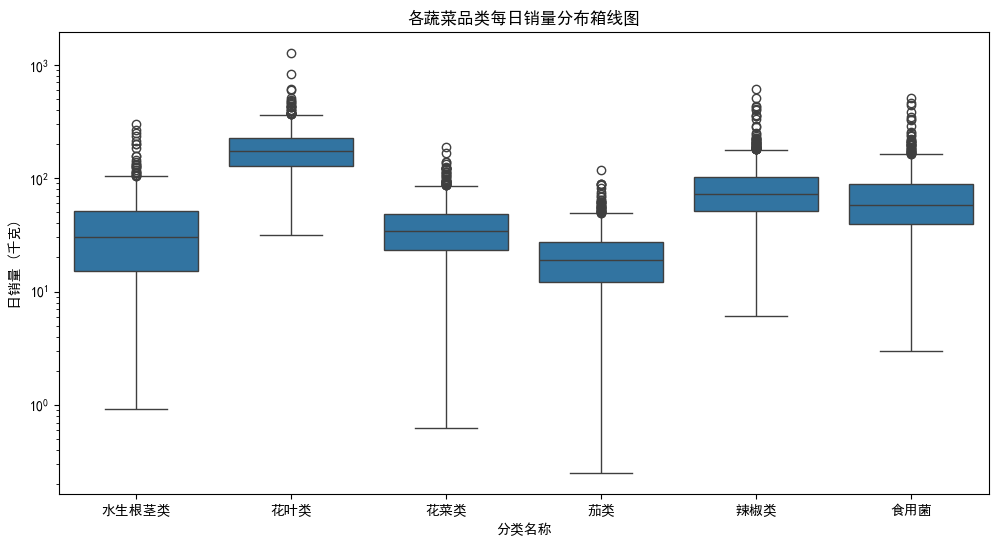

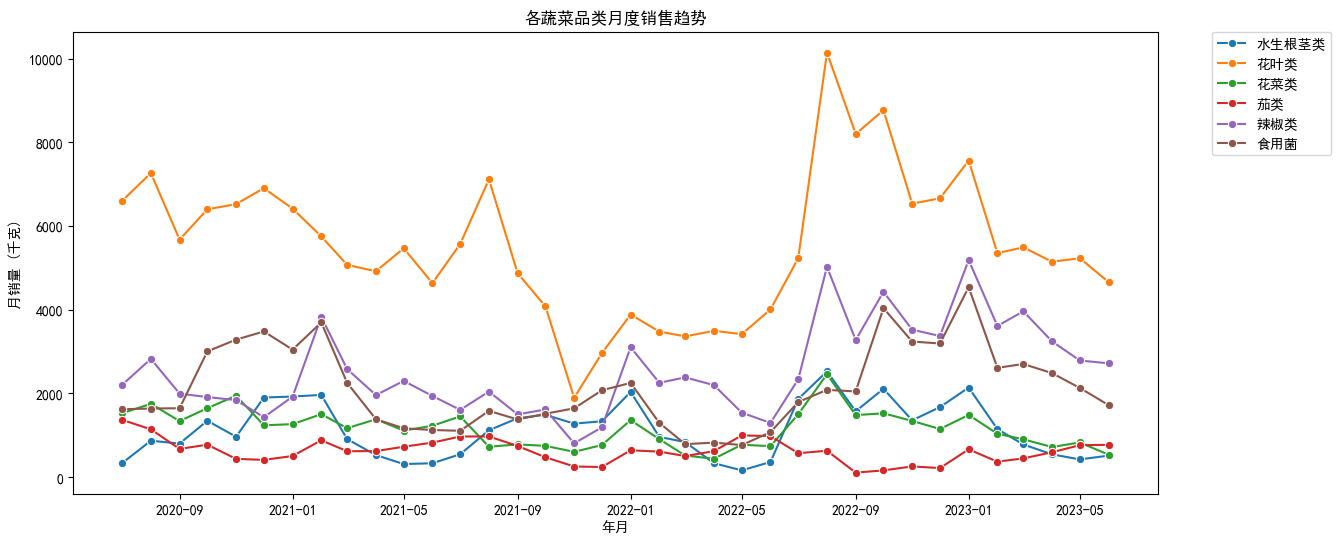

In [9]:
analyze_distribution_patterns(df_q1)

单品销量前十+年/季销售额

In [10]:
print("单品销量前十:")
sales_by_cat = df_q1.groupby('单品名称')['销量'].sum().sort_values(ascending=False)
for cat, sales in sales_by_cat.head(10).items():
    print(f"  {cat}: {sales:,.1f}kg")

单品销量前十:
  芜湖青椒(1): 28,181.7kg
  西兰花: 27,555.9kg
  净藕(1): 27,166.5kg
  大白菜: 19,196.1kg
  云南生菜: 15,915.4kg
  金针菇(盒): 15,602.0kg
  云南生菜(份): 14,335.0kg
  紫茄子(2): 13,609.0kg
  西峡香菇(1): 11,929.1kg
  小米椒(份): 10,847.0kg


In [11]:
#各品类销售额
df_q1['销售额'] = df_q1['销量'] * df_q1['单价']

# 按年份和分类汇总销量和销售额
yearly = df_q1.groupby(['年份', '分类名称']).agg({
    '销量': 'sum',
    '销售额': 'sum',
}).reset_index()

print("\n各品类年度销量和销售额:")
years = sorted(yearly['年份'].unique())
for year in years:
    year_data = yearly[yearly['年份'] == year]
    print(f"\n{year}年:")
    print(f"{'分类':<8} {'销量(kg)':>12} {'销售额(元)':>15}")
    for _, row in year_data.sort_values('销售额', ascending=False).head(6).iterrows():
        print(f"{row['分类名称']:<8} {row['销量']:12,.0f} {row['销售额']:15,.0f}")

# 年度增长率（销量和销售额）
print("\n年度增长率（销量和销售额）:")
top_cats = yearly.groupby('分类名称')['销售额'].sum().nlargest(6).index

for cat in top_cats:
    cat_data = yearly[yearly['分类名称'] == cat].sort_values('年份')
    if len(cat_data) >= 2:
        first_year = cat_data.iloc[0]
        last_year = cat_data.iloc[-1]
        
        # 销量增长率
        sales_growth = (last_year['销量'] - first_year['销量']) / first_year['销量'] * 100 if first_year['销量'] > 0 else 0
        
        # 销售额增长率
        revenue_growth = (last_year['销售额'] - first_year['销售额']) / first_year['销售额'] * 100 if first_year['销售额'] > 0 else 0
        
    
        
        print(f"\n{cat}:")
        print(f"  销量增长率（2020-2023）: {sales_growth:+.1f}% ({first_year['销量']:,.0f}kg → {last_year['销量']:,.0f}kg)")
        print(f"  销售额增长率（2020-2023）: {revenue_growth:+.1f}% (¥{first_year['销售额']:,.0f} → ¥{last_year['销售额']:,.0f})")



各品类年度销量和销售额:

2020年:
分类             销量(kg)          销售额(元)
花叶类            39,352         234,650
食用菌            14,661         138,305
辣椒类            12,192         125,583
花菜类             9,433          84,200
水生根茎类           6,203          52,666
茄类              4,791          34,606

2021年:
分类             销量(kg)          销售额(元)
花叶类            58,725         365,166
辣椒类            23,257         236,554
食用菌            21,934         207,111
水生根茎类          13,110         116,907
花菜类            12,702         112,214
茄类              7,799          63,219

2022年:
分类             销量(kg)          销售额(元)
花叶类            67,152         308,695
辣椒类            34,702         247,161
食用菌            23,362         168,663
水生根茎类          15,761         131,540
花菜类            14,163         122,335
茄类              6,260          58,956

2023年:
分类             销量(kg)          销售额(元)
花叶类            33,430         171,325
辣椒类            21,494         145,266
食用菌            16,173         106,031
花菜类 

In [12]:
quarterly = df_q1.groupby(['季度', '分类名称']).agg({
    '销量': 'mean'  # 季度日均销量
}).reset_index()

quarter_names = {1: 'Q1(1-3月)', 2: 'Q2(4-6月)', 3: 'Q3(7-9月)', 4: 'Q4(10-12月)'}

print("\n各季度平均日销量 (kg):")
for quarter in [1, 2, 3, 4]:
    quarter_data = quarterly[quarterly['季度'] == quarter]
    print(f"\n{quarter_names[quarter]}:")
    for _, row in quarter_data.sort_values('销量', ascending=False).head(3).iterrows():
        print(f"  {row['分类名称']}: {row['销量']:.1f}kg/天")

# 季节性分析
print("\n季节性分析（旺季/淡季）:")
for cat in quarterly['分类名称'].unique()[:6]:
    cat_data = quarterly[quarterly['分类名称'] == cat]
    peak = cat_data.loc[cat_data['销量'].idxmax()]
    low = cat_data.loc[cat_data['销量'].idxmin()]
    diff = (peak['销量'] - low['销量']) / low['销量'] * 100
    print(f"  {cat}: 旺季{quarter_names[peak['季度']]}, 淡季{quarter_names[low['季度']]}, 差异{diff:.0f}%")


各季度平均日销量 (kg):

Q1(1-3月):
  水生根茎类: 0.8kg/天
  花叶类: 0.7kg/天
  食用菌: 0.6kg/天

Q2(4-6月):
  花叶类: 0.6kg/天
  食用菌: 0.5kg/天
  水生根茎类: 0.5kg/天

Q3(7-9月):
  水生根茎类: 0.7kg/天
  花叶类: 0.6kg/天
  茄类: 0.5kg/天

Q4(10-12月):
  水生根茎类: 0.7kg/天
  花叶类: 0.6kg/天
  食用菌: 0.5kg/天

季节性分析（旺季/淡季）:
  水生根茎类: 旺季Q1(1-3月), 淡季Q2(4-6月), 差异58%
  花叶类: 旺季Q1(1-3月), 淡季Q2(4-6月), 差异18%
  花菜类: 旺季Q1(1-3月), 淡季Q3(7-9月), 差异4%
  茄类: 旺季Q3(7-9月), 淡季Q1(1-3月), 差异8%
  辣椒类: 旺季Q1(1-3月), 淡季Q3(7-9月), 差异24%
  食用菌: 旺季Q1(1-3月), 淡季Q3(7-9月), 差异39%


In [13]:
#周末对比平常

df_q1['是否周末'] = df_q1['是否周末'].astype(bool)

# 按品类和是否周末分组，计算每组销量的均值
grouped = df_q1.groupby(['分类名称', '是否周末'])['销量'].mean().reset_index()

# 重塑数据，将是否周末作为列名
pivot_table = grouped.pivot(index='分类名称', columns='是否周末', values='销量')
# 重命名列名，便于识别
pivot_table.columns = ['平时销量均值', '周末销量均值']

pivot_table['周末/平时销量均值比值'] = pivot_table['周末销量均值'] / pivot_table['平时销量均值']
pivot_table['销量均值差值'] = pivot_table['周末销量均值'] - pivot_table['平时销量均值']
pivot_table['周末还是平时卖得好'] = pivot_table['周末/平时销量均值比值'].apply(
    lambda x: '周末' if x > 1 else '平时'
)
# 打印结果
print(pivot_table)

         平时销量均值    周末销量均值  周末/平时销量均值比值    销量均值差值 周末还是平时卖得好
分类名称                                                      
水生根茎类  0.688847  0.699594     1.015602  0.010747        周末
花叶类    0.601549  0.593691     0.986938 -0.007858        平时
花菜类    0.479635  0.489049     1.019627  0.009414        周末
茄类     0.499271  0.501412     1.004288  0.002141        周末
辣椒类    0.441048  0.440426     0.998591 -0.000621        平时
食用菌    0.513223  0.513217     0.999988 -0.000006        平时


相关分析

In [14]:
from scipy import stats

# 对原有的数据分组聚合逻辑添加日志输出，方便用户了解函数功能和数据处理进展
def summarize_data(df_q1):
    #对数据按日期和品类进行汇总，计算每个品类每天的总销量、平均单价和总销售额。
    daily_summary = df_q1.groupby(['日期', '分类名称']).agg({
        '销量': 'sum',
        '单价': 'mean',
        '销售额': 'sum'
    }).reset_index()
    return daily_summary

# 封装相关性计算逻辑，让代码结构更清晰，便于复用和测试
def calculate_spearman_correlation(daily_summary):
    #计算每个品类价格与销量的Spearman相关系数，并分析相关性强度、显著性和方向。
    spearman_results = []
    for cat in daily_summary['分类名称'].unique():
        cat_data = daily_summary[daily_summary['分类名称'] == cat]
        if len(cat_data) >= 10:  # 至少需要10天数据
            # 计算Spearman相关系数（更稳健，适用于非线性关系）
            price_sales_corr, price_sales_p = stats.spearmanr(cat_data['单价'], cat_data['销量'])
            # 判断相关性强度
            strength = get_correlation_strength(price_sales_corr)
            # 判断显著性 (p < 0.05 为显著相关)
            significant = "显著" if price_sales_p < 0.05 else "不显著"
            direction = "负相关" if price_sales_corr < 0 else "正相关"
            spearman_results.append({
                '分类名称': cat,
                'Spearman相关系数': round(price_sales_corr, 3),
                'p值': round(price_sales_p, 3),
                '显著性': significant,
                '相关性强度': strength,
                '方向': direction,
                '数据天数': len(cat_data)
            })
    return pd.DataFrame(spearman_results).sort_values('Spearman相关系数')

# 将相关性强度判断逻辑封装成函数，提高代码的复用性和可维护性
def get_correlation_strength(corr):
    #根据相关系数判断相关性强度。
    #param corr: 相关系数
    
    if abs(corr) > 0.5:
        return "强"
    elif abs(corr) > 0.3:
        return "中等"
    elif abs(corr) > 0.1:
        return "弱"
    else:
        return "无"

# 封装结果打印逻辑，使代码更模块化，便于代码的修改和扩展
def print_correlation_results(spearman_df):
    #打印各品类价格与销量的Spearman相关性分析结果。
    print("\n各品类价格与销量Spearman相关性分析:")
    print(f"{'分类名称':<10} {'Spearman相关系数':>15} {'p值':>10} {'显著性':>8} {'强度':>8} {'方向':>8}")
    for _, row in spearman_df.iterrows():
        print(f"{row['分类名称']:<10} {row['Spearman相关系数']:15.3f} {row['p值']:10.3f} "
              f"{row['显著性']:>8} {row['相关性强度']:>8} {row['方向']:>8}")

# 分析显著相关的品类，并打印结果，使代码结构更清晰，功能模块化
def analyze_significant_correlations(spearman_df):
    print("\n显著相关的品类 (p < 0.05):")
    significant_corr = spearman_df[spearman_df['显著性'] == '显著']
    if len(significant_corr) > 0:
        # 强负相关
        strong_neg = significant_corr[(significant_corr['Spearman相关系数'] < -0.5)]
        # 中等负相关
        medium_neg = significant_corr[(significant_corr['Spearman相关系数'] >= -0.5) &
                                      (significant_corr['Spearman相关系数'] < -0.3)]
        # 弱负相关
        weak_neg = significant_corr[(significant_corr['Spearman相关系数'] >= -0.3) &
                                    (significant_corr['Spearman相关系数'] < -0.1)]
        # 弱正相关
        weak_pos = significant_corr[(significant_corr['Spearman相关系数'] >= 0.1) &
                                    (significant_corr['Spearman相关系数'] < 0.3)]
        # 中等正相关
        medium_pos = significant_corr[(significant_corr['Spearman相关系数'] >= 0.3) &
                                      (significant_corr['Spearman相关系数'] < 0.5)]
        # 强正相关
        strong_pos = significant_corr[(significant_corr['Spearman相关系数'] >= 0.5)]

        print_correlation_category(strong_neg, "强负相关")
        print_correlation_category(medium_neg, "中等负相关")
        print_correlation_category(weak_neg, "弱负相关")
        print_correlation_category(weak_pos, "弱正相关")
        print_correlation_category(medium_pos, "中等正相关")
        print_correlation_category(strong_pos, "强正相关")
    else:
        print("无显著相关的品类。")

# 封装打印特定相关性类别品类的逻辑，减少代码重复，提高代码的可维护性
def print_correlation_category(category_df, category_name):
    if not category_df.empty:
        print(f"\n{category_name}:")
        for _, row in category_df.iterrows():
            print(f"  {row['分类名称']}: r={row['Spearman相关系数']:.3f}, p={row['p值']:.3f}")

# 主函数
def main(df_q1):
    daily_summary = summarize_data(df_q1)
    spearman_df = calculate_spearman_correlation(daily_summary)
    print_correlation_results(spearman_df)
    analyze_significant_correlations(spearman_df)

main(df_q1)


各品类价格与销量Spearman相关性分析:
分类名称          Spearman相关系数         p值      显著性       强度       方向
食用菌                 -0.462      0.000       显著       中等      负相关
水生根茎类               -0.442      0.000       显著       中等      负相关
辣椒类                 -0.313      0.000       显著       中等      负相关
茄类                  -0.298      0.000       显著        弱      负相关
花菜类                 -0.271      0.000       显著        弱      负相关
花叶类                 -0.160      0.000       显著        弱      负相关

显著相关的品类 (p < 0.05):

中等负相关:
  食用菌: r=-0.462, p=0.000
  水生根茎类: r=-0.442, p=0.000
  辣椒类: r=-0.313, p=0.000

弱负相关:
  茄类: r=-0.298, p=0.000
  花菜类: r=-0.271, p=0.000
  花叶类: r=-0.160, p=0.000


In [15]:
def analyze_category_correlations(data):
    pivot_df = data.groupby(['日期', '分类名称'])['销量'].sum().unstack()
    pivot_df = pivot_df.fillna(0)
    
    # 2. 计算相关系数 (Spearman 更适合非正态分布的销量数据)
    corr_matrix = pivot_df.corr(method='spearman')
    
    # 3. 绘制热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title('蔬菜品类间销售量的相关性热力图 (Spearman)')
    plt.show()
    
    print("关联性解读:")
    # 获取上三角矩阵（去除重复和自相关）
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    strong_corr = corr_matrix.where(mask).stack()
    
    # 筛选绝对值大于 0.6 的强相关
    strong_pairs = strong_corr[abs(strong_corr) > 0.5].sort_values(ascending=False)
    if not strong_pairs.empty:
        print("发现以下品类存在强相关性 (可能是季节同步或互补):")
        print(strong_pairs)
    else:
        print("未发现明显的强相关性 (各品类销售相对独立)。")

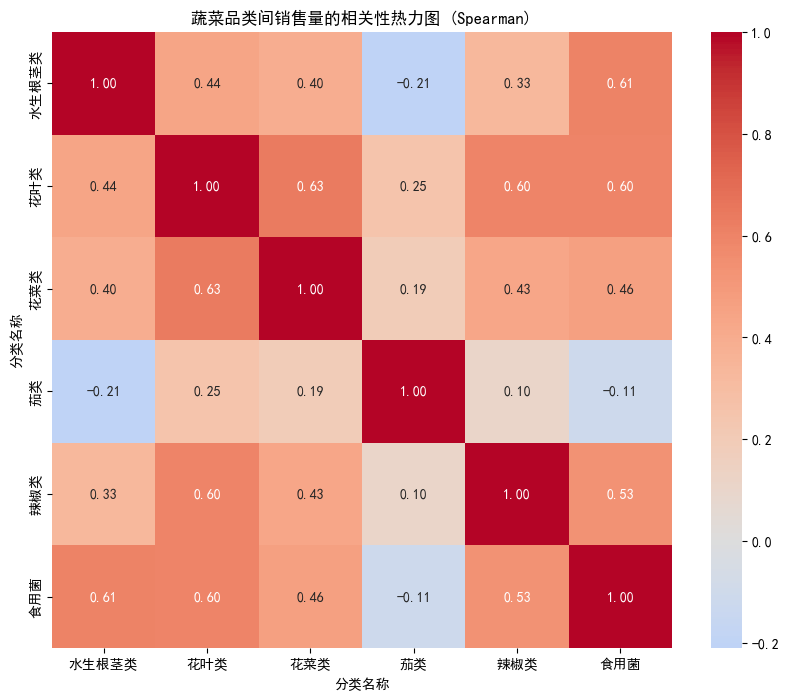

关联性解读:
发现以下品类存在强相关性 (可能是季节同步或互补):
分类名称   分类名称
花叶类    花菜类     0.633454
水生根茎类  食用菌     0.605350
花叶类    食用菌     0.596222
       辣椒类     0.595045
辣椒类    食用菌     0.534781
dtype: float64


In [16]:
analyze_category_correlations(df_q1)